## 자전거 대여량 예측 EDA 따라하기 <span style="color:gray">|[출처](https://www.kaggle.com/viveksrinivasan/eda-ensemble-model-top-10-percentile)</span>
* 데이터셋 설명
    * 도시의 키오스크 기계로 자전거를 대여한 기록

* 데이터 요약
* Feature Engineering
* 결측치 처리
* 이상치 처리
* 상관관계 분석
* 데이터 시각화
* 모델링 

#### 평가지표: RMSE
---

#### 라이브러리 import

In [2]:
import pylab
import calendar
import numpy as np
import pandas as pd
import seaborn as sns   # 시각화 패키지
from scipy import stats
import missingno as msno   # 결측치 처리 패키지 
from datetime import datetime   # 시간을 다루는 패키지 
import matplotlib.pyplot as plt   # 시각화 퍀지 
import warnings   # 경고 메세지 출력 관련 패키지 
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=DeprecationWarning)  
%matplotlib inline  # 그래프 내에 그림을 inline 방식으로 그리고자 

UsageError: unrecognized arguments: # 그래프 내에 그림을 inline 방식으로 그리고자


In [3]:
dailyData = pd.read_csv("data/bike-sharing-demand/train.csv") #  parse_dates =["datetime"]: datetime은 datetime 형식으로 불러오게 함. 
print("Data head\n{}".format(dailyData.head(2)))
print("-"*80)
print("Data summary\n{}".format(dailyData.describe()))
print("-"*80)
print("Data Type\n{}".format(dailyData.dtypes))

Data head
              datetime  season  holiday  workingday  weather  temp   atemp  \
0  2011-01-01 00:00:00       1        0           0        1  9.84  14.395   
1  2011-01-01 01:00:00       1        0           0        1  9.02  13.635   

   humidity  windspeed  casual  registered  count  
0        81        0.0       3          13     16  
1        80        0.0       8          32     40  
--------------------------------------------------------------------------------
Data summary
             season       holiday    workingday       weather         temp  \
count  10886.000000  10886.000000  10886.000000  10886.000000  10886.00000   
mean       2.506614      0.028569      0.680875      1.418427     20.23086   
std        1.116174      0.166599      0.466159      0.633839      7.79159   
min        1.000000      0.000000      0.000000      1.000000      0.82000   
25%        2.000000      0.000000      0.000000      1.000000     13.94000   
50%        3.000000      0.000000    

* datetime: 시간
* season: 계절 (1,2,3,4)
* holiday: 휴일 유무 (0,1)
* workingday
* weather
    * 1: 맑고 구름이 거의 없으며 부분적으로 흐림
    * 2: 안개+흐림, 안개+부서진 구름
    * 3: 가벼운 눈, 가벼운 비+구름
    * 4: 폭우, 눈+안
* temp: 온도
* atemp: 체감 온도 
* humidity: 습도 
* windspeed: 풍속
* casual: 등록된 사용자가 아님 
* registered: 등록된 사용자 
* count: 대여 수 

#### Feature Engineering

split하여 날짜와 시간을 분리함. 

In [4]:
# dailyData["year"] = dailyData["datetime"].dt.year
# dailyData["month"] = dailyData["datetime"].dt.month
# dailyData["day"] = dailyData["datetime"].dt.day
# dailyData["hour"] = dailyData["datetime"].dt.hour
# dailyData["minute"] = dailyData["datetime"].dt.minute
# dailyData["second"] = dailyData["datetime"].dt.second
# dailyData["weekday"] = dailyData["datetime"].dt.weekday

dailyData["date"] = dailyData.datetime.apply(lambda x : x.split()[0])
dailyData["hour"] = dailyData.datetime.apply(lambda x : x.split()[1].split(":")[0])
dailyData["weekday"] = dailyData.date.apply(lambda dateString : calendar.day_name[datetime.strptime(dateString,"%Y-%m-%d").weekday()])
dailyData["month"] = dailyData.date.apply(lambda dateString : calendar.month_name[datetime.strptime(dateString,"%Y-%m-%d").month])
dailyData["season"] = dailyData.season.map({1: "Spring", 2 : "Summer", 3 : "Fall", 4 :"Winter" })
dailyData["weather"] = dailyData.weather.map({1: " Clear + Few clouds + Partly cloudy + Partly cloudy",\
                                        2 : " Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist ", \
                                        3 : " Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds", \
                                        4 :" Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog " })


In [5]:
dailyData.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,hour,weekday,month
0,2011-01-01 00:00:00,Spring,0,0,Clear + Few clouds + Partly cloudy + Partly c...,9.84,14.395,81,0.0,3,13,16,2011-01-01,00,Saturday,January
1,2011-01-01 01:00:00,Spring,0,0,Clear + Few clouds + Partly cloudy + Partly c...,9.02,13.635,80,0.0,8,32,40,2011-01-01,01,Saturday,January
2,2011-01-01 02:00:00,Spring,0,0,Clear + Few clouds + Partly cloudy + Partly c...,9.02,13.635,80,0.0,5,27,32,2011-01-01,02,Saturday,January
3,2011-01-01 03:00:00,Spring,0,0,Clear + Few clouds + Partly cloudy + Partly c...,9.84,14.395,75,0.0,3,10,13,2011-01-01,03,Saturday,January
4,2011-01-01 04:00:00,Spring,0,0,Clear + Few clouds + Partly cloudy + Partly c...,9.84,14.395,75,0.0,0,1,1,2011-01-01,04,Saturday,January


카테고리 변수로 변형 

In [6]:
categoryVariableList = ["hour","weekday","month","season","weather","holiday","workingday"]
for var in categoryVariableList:
    dailyData[var] = dailyData[var].astype("category")

In [7]:
dailyData.info()  # dtype이랑 null 유무를 같이 볼 수 있음. 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   datetime    10886 non-null  object  
 1   season      10886 non-null  category
 2   holiday     10886 non-null  category
 3   workingday  10886 non-null  category
 4   weather     10886 non-null  category
 5   temp        10886 non-null  float64 
 6   atemp       10886 non-null  float64 
 7   humidity    10886 non-null  int64   
 8   windspeed   10886 non-null  float64 
 9   casual      10886 non-null  int64   
 10  registered  10886 non-null  int64   
 11  count       10886 non-null  int64   
 12  date        10886 non-null  object  
 13  hour        10886 non-null  category
 14  weekday     10886 non-null  category
 15  month       10886 non-null  category
dtypes: category(7), float64(3), int64(4), object(2)
memory usage: 842.1+ KB


In [8]:
dailyData  = dailyData.drop(["datetime"],axis=1) # 불필요해진 변수 삭제 

#### EDA

#### 결측치 확인

<AxesSubplot:>

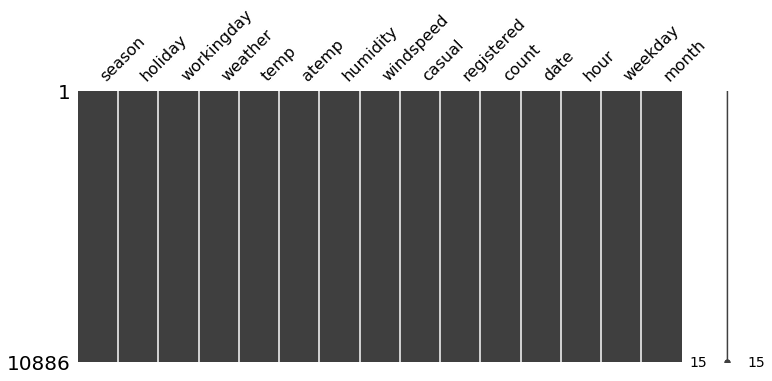

In [9]:
msno.matrix(dailyData,figsize=(12,5))

In [10]:
dailyData.isnull().sum()

season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
date          0
hour          0
weekday       0
month         0
dtype: int64

[Text(0.5, 0, 'Working Day'),
 Text(0, 0.5, 'Count'),
 Text(0.5, 1.0, 'Box Plot On Count Across Working Day')]

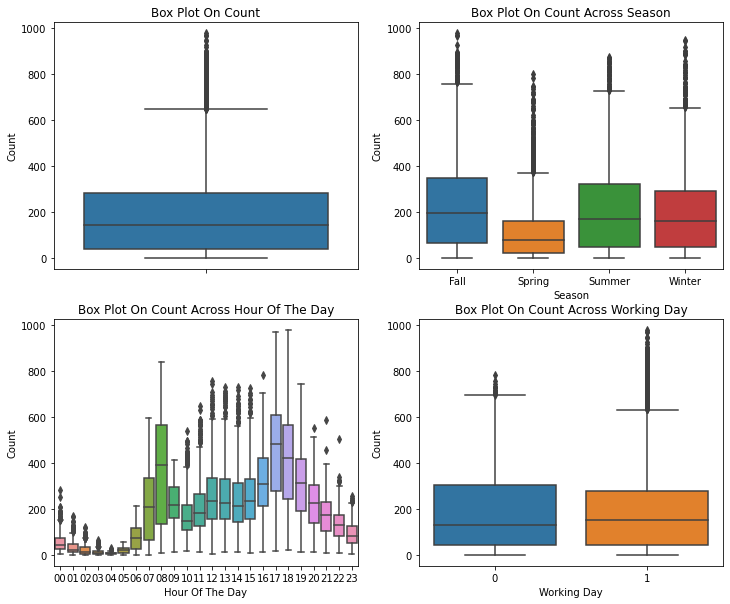

In [12]:
fig, axes = plt.subplots(nrows=2,ncols=2, figsize = (12, 10))
# fig.set_size_inches(12, 10)
sns.boxplot(data=dailyData,y="count",orient="v",ax=axes[0][0])
sns.boxplot(data=dailyData,y="count",x="season",orient="v",ax=axes[0][1])
sns.boxplot(data=dailyData,y="count",x="hour",orient="v",ax=axes[1][0])
sns.boxplot(data=dailyData,y="count",x="workingday",orient="v",ax=axes[1][1])

axes[0][0].set(ylabel='Count',title="Box Plot On Count")
axes[0][1].set(xlabel='Season', ylabel='Count',title="Box Plot On Count Across Season")
axes[1][0].set(xlabel='Hour Of The Day', ylabel='Count',title="Box Plot On Count Across Hour Of The Day")
axes[1][1].set(xlabel='Working Day', ylabel='Count',title="Box Plot On Count Across Working Day")

#### count 변수의 이상치 확인

[Text(0.5, 0, 'Working Day'),
 Text(0, 0.5, 'Count'),
 Text(0.5, 1.0, 'Box Plot On Count Across Working Day')]

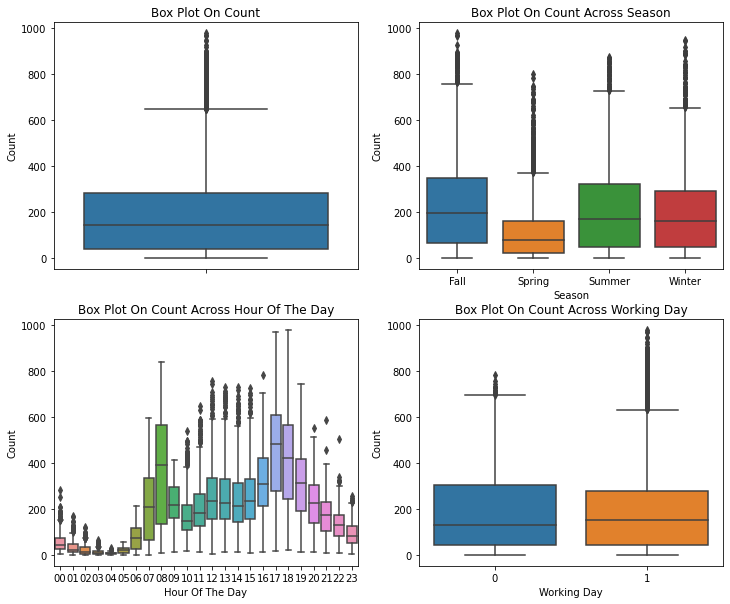

In [13]:
fig, axes = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(12, 10)

sns.boxplot(data=dailyData,y="count",orient="v",ax=axes[0][0])  # orient="v" 상자그림을 세로로 그리기 
sns.boxplot(data=dailyData,y="count",x="season",orient="v",ax=axes[0][1])
sns.boxplot(data=dailyData,y="count",x="hour",orient="v",ax=axes[1][0])
sns.boxplot(data=dailyData,y="count",x="workingday",orient="v",ax=axes[1][1])

axes[0][0].set(ylabel='Count',title="Box Plot On Count")
axes[0][1].set(xlabel='Season', ylabel='Count',title="Box Plot On Count Across Season")
axes[1][0].set(xlabel='Hour Of The Day', ylabel='Count',title="Box Plot On Count Across Hour Of The Day")
axes[1][1].set(xlabel='Working Day', ylabel='Count',title="Box Plot On Count Across Working Day")

* 계절별로 보았을 때 봄에 대여량이 가장 적고 여름, 가을, 겨울 순으로 대여량이 많음.
* 크게 차이는 없지만 근무하지 않는 날의 대여량이 더 많은 것을 확인할 수 있음. 

In [20]:
dailyDataWithoutOutliers = dailyData[np.abs(dailyData["count"]-dailyData["count"].mean())<=(3*dailyData["count"].std())] 

In [142]:
print ("Shape Of The Before Ouliers: ",dailyData.shape)
print ("Shape Of The After Ouliers: ",dailyDataWithoutOutliers.shape)

Shape Of The Before Ouliers:  (10886, 15)
Shape Of The After Ouliers:  (10739, 15)


147개 이상치들이 제거됨

[Text(0.5, 0, 'Hour Of The Day'),
 Text(0, 0.5, 'Users Count'),
 Text(0.5, 1.0, 'Average Users Count By Hour Of The Day Across Workingday Type'),
 None]

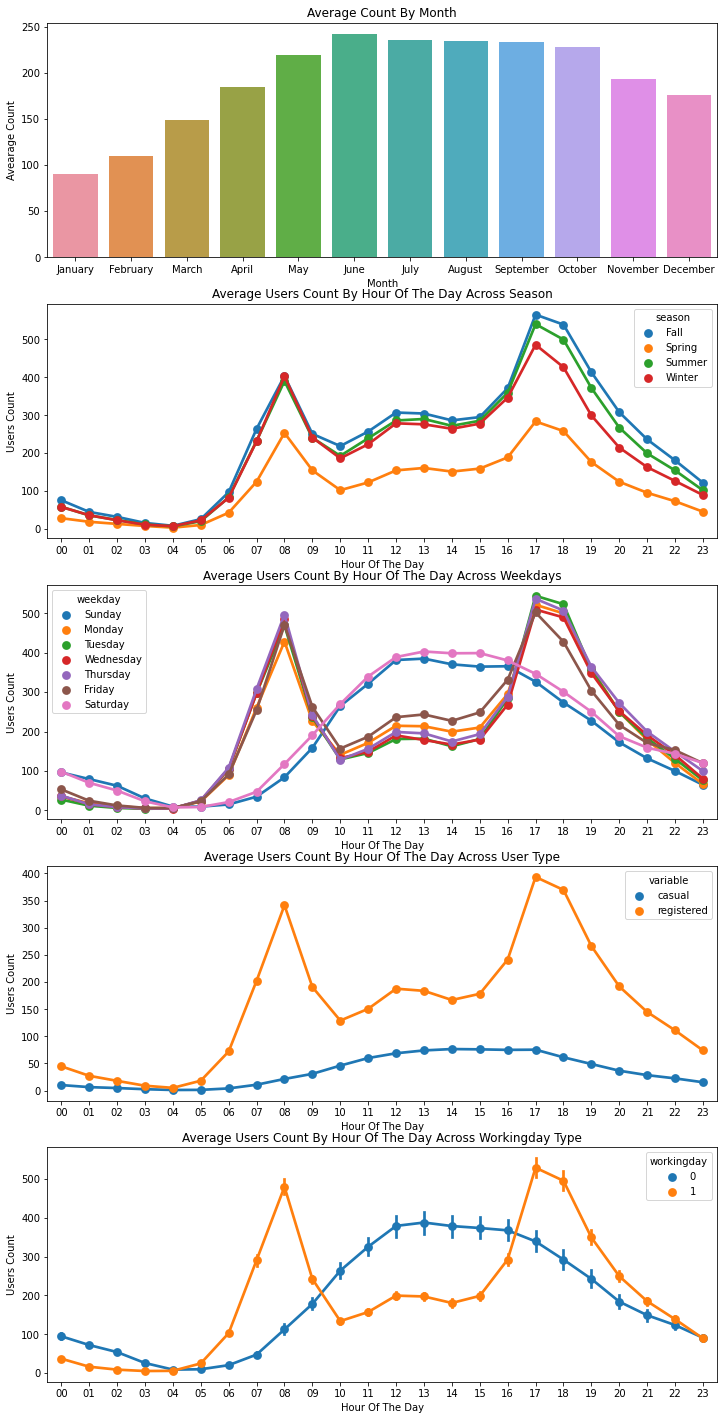

In [14]:
fig,(ax1,ax2,ax3,ax4,ax5)= plt.subplots(nrows=5)
fig.set_size_inches(12,25)

sortOrder = ["January","February","March","April","May","June","July","August","September","October","November","December"]
hueOrder = ["Sunday","Monday","Tuesday","Wednesday","Thursday","Friday","Saturday"]

monthAggregated = pd.DataFrame(dailyData.groupby("month")["count"].mean()).reset_index()
monthSorted = monthAggregated.sort_values(by="count",ascending=False)

sns.barplot(data=monthSorted,x="month",y="count",ax=ax1,order=sortOrder)
ax1.set(xlabel='Month', ylabel='Avearage Count',title="Average Count By Month")

hourAggregated = pd.DataFrame(dailyData.groupby(["hour","season"],sort=True)["count"].mean()).reset_index()
sns.pointplot(x=hourAggregated["hour"], y=hourAggregated["count"],hue=hourAggregated["season"], data=hourAggregated, join=True,ax=ax2)
ax2.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day Across Season",label='big')

hourAggregated = pd.DataFrame(dailyData.groupby(["hour","weekday"],sort=True)["count"].mean()).reset_index()
sns.pointplot(x=hourAggregated["hour"], y=hourAggregated["count"],hue=hourAggregated["weekday"],hue_order=hueOrder, data=hourAggregated, join=True,ax=ax3)
ax3.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day Across Weekdays",label='big')

hourTransformed = pd.melt(dailyData[["hour","casual","registered"]], id_vars=['hour'], value_vars=['casual', 'registered'])
hourAggregated = pd.DataFrame(hourTransformed.groupby(["hour","variable"],sort=True)["value"].mean()).reset_index()
sns.pointplot(x=hourAggregated["hour"], y=hourAggregated["value"],hue=hourAggregated["variable"],hue_order=["casual","registered"], data=hourAggregated, join=True,ax=ax4)
ax4.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day Across User Type",label='big')

sns.pointplot(data=dailyData, x="hour", y="count", hue="workingday",ax=ax5)
ax5.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day Across Workingday Type",label='big')



* 월별 대여량을 보았을 때 6월에 가장 많음. 
* 봄, 겨울, 여름, 가을 순으로 대여량이 많아짐.
* 시간별로 확인했을 때 계절별로는 비슷한 양상으로 아침 8시에 대여량이 높고 17-19시 사이의 대여량이 높음.
    * 출퇴근 시간에 많은 것으로 추정.
* 요일별로 확인했을 때 토요일과 일요일인 주말에 비슷한 양상, 평일끼리 비슷한 양상을 보임.
    * workingday에 따라 다른 것으로 추정. 
* workingday 기준으로 나눠봤을 때 
    * 일하지 않는 날은 12-17시까지 시간 대의 대여량이 많고 일하는 날에는 출퇴근 시간에 많은 것으로 보임

#### 상관관계

<AxesSubplot:>

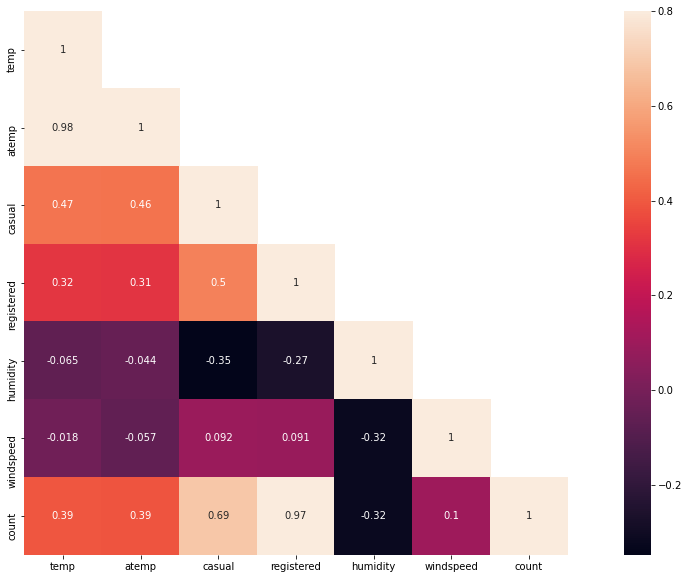

In [15]:
corrMatt = dailyData[["temp","atemp","casual","registered","humidity","windspeed","count"]].corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots(figsize = (20,10))
sns.heatmap(corrMatt, mask=mask,vmax=.8, square=True,annot=True)

* 종속 변수인 count와 큰 양의 상관관계를 갖고 있는 변수는 registered 변수,casual 변수
    * registered변수와 casual 변수는 test데이터에 없는 변수로 사용하기 부적절한 변수
* 보통의 상관관계를 갖는 변수는 temp, atemp, humidity 변수.
* 약한 양의 상관관계를 갖는 변수는 windspeed 변수
* 이로써, 온도, 습도, 풍속 변수는 종속변수와 관계가 없다고 할 수 있음.
* atemp와 temp 변수 간 상관관계는 0.98로 매우 높은 관계가 있기 때문에 다중공선성 우려가 있고 둘 중 하나는 삭제되어야 하는 변수


<AxesSubplot:xlabel='humidity', ylabel='count'>

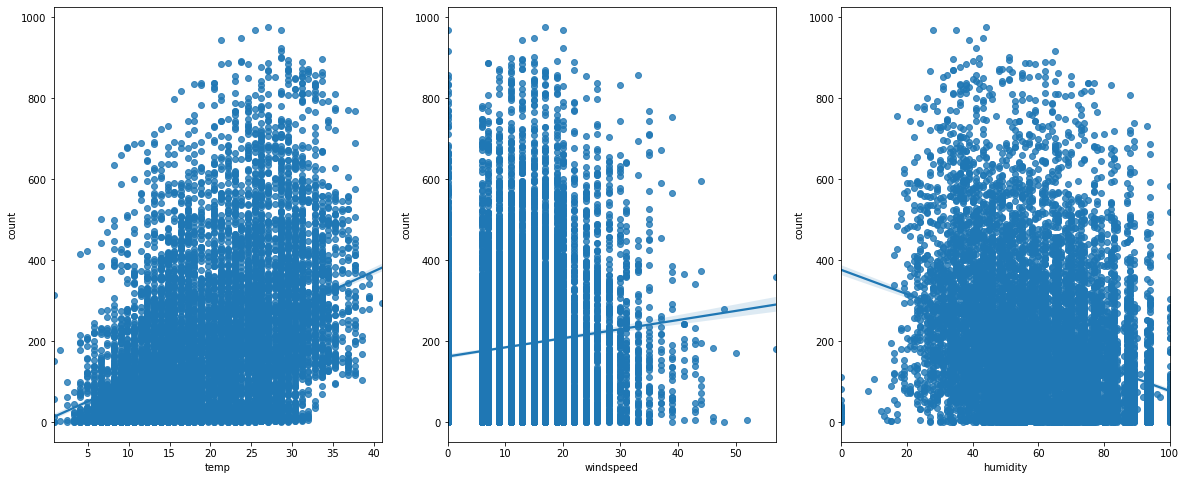

In [18]:
fig,(ax1,ax2,ax3) = plt.subplots(ncols=3, figsize = (20,8))

sns.regplot(x="temp", y="count", data=dailyData,ax=ax1)
sns.regplot(x="windspeed", y="count", data=dailyData,ax=ax2)
sns.regplot(x="humidity", y="count", data=dailyData,ax=ax3)

* 온도, 습도, 풍속에 따른 대여량의 산점도를 확인한 결과 풍속은 0에 데이터가 몰려있는 것을 볼 수 있음. 
* 습도는 0과 100에 몰려있음. 
* 풍속에 0이 데이터가 몰려있는 것이 맞는 데이터인 지 확인할 필요가 있음. 

#### 데이터 분포 파악

C:\Users\a0105\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\a0105\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\a0105\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

((array([-3.82819677, -3.60401975, -3.48099008, ...,  3.48099008,
          3.60401975,  3.82819677]),
  array([0.69314718, 0.69314718, 0.69314718, ..., 6.5971457 , 6.59850903,
         6.5998705 ])),
 (1.3486990121229776, 4.562423868087808, 0.9581176780909612))

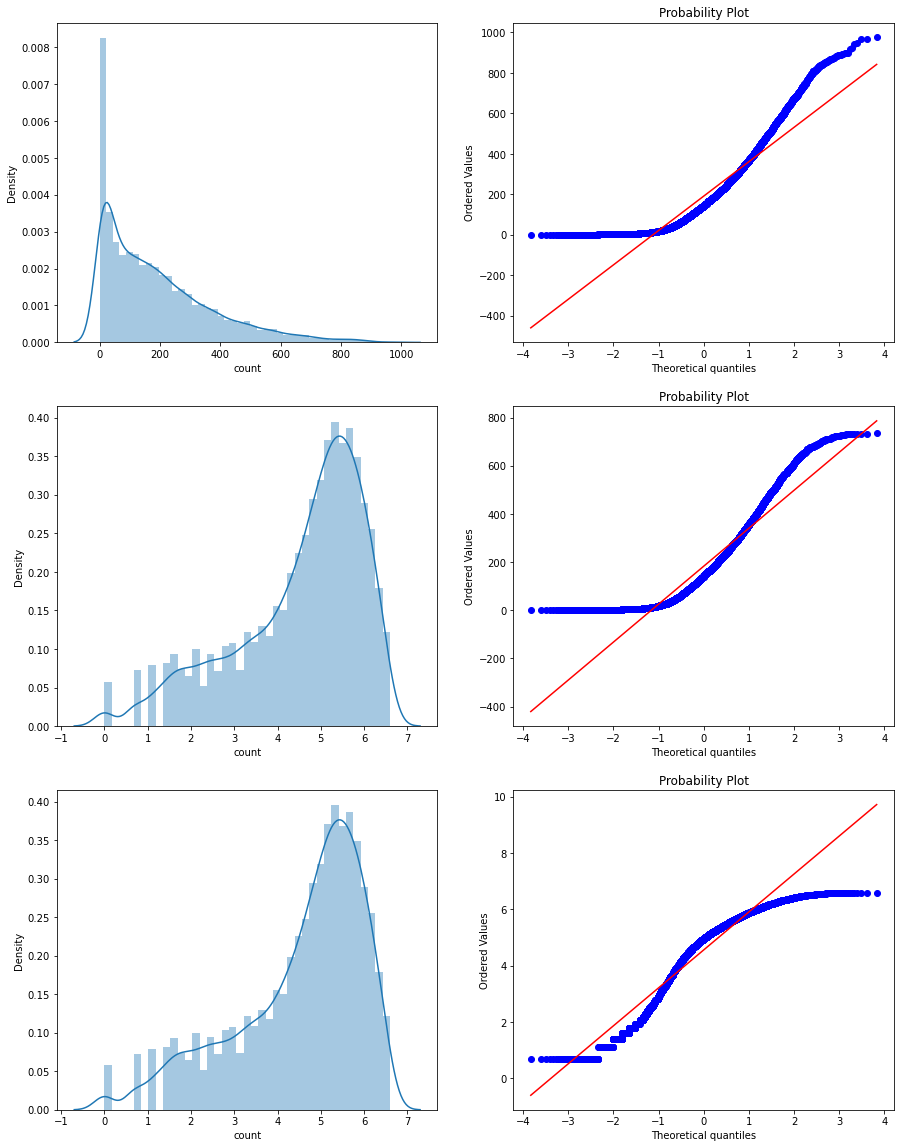

In [21]:
fig,axes = plt.subplots(ncols=2,nrows=3)
fig.set_size_inches(15, 20)
sns.distplot(dailyData["count"],ax=axes[0][0])
stats.probplot(dailyData["count"], dist='norm', fit=True, plot=axes[0][1])

sns.distplot(np.log(dailyDataWithoutOutliers["count"]),ax=axes[1][0])
stats.probplot(dailyDataWithoutOutliers["count"], dist='norm', fit=True, plot=axes[1][1])

sns.distplot(np.log(dailyDataWithoutOutliers["count"]),ax=axes[2][0])
stats.probplot(np.log1p(dailyDataWithoutOutliers["count"]), dist='norm', fit=True, plot=axes[2][1])

* 이상치를 제거하고 종속변수가 정규분포를 따르는지 확인한 결과 여전히 오른쪽으로 치우쳐져 있음.
    * 대부분의 기계학습은 종속변수가 normal이어야 하기 때문에 정규분포를 따르는 것이 바람직함. 
* count 변수에 log를 씌워도 딱히 큰 변화가 없음. 